# SimpleNet - Development Notebook

Notebook to try different parameters for SimpleNet.

## Base architecture

<img src="../../../doc/assets/simplenet_arch.png"/>

Note: Diagram generated with [NN-SVG by Alex Nail](http://alexlenail.me/NN-SVG/)

In [1]:
import sys
WORKSPACE_BASE_PATH="/tf/notebooks/" # Parent directory containing src, checkpoints, models, etc.
CODE_BASE_PATH="/tf/notebooks/src/" # Path were components are stored.
DATA_BASE_PATH="/tf/notebooks/data/" # Directory with data in case it is not inside WORKSPACE BASE path.
sys.path.append(CODE_BASE_PATH)

In [2]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ELU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

from IPython.display import SVG
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

## Model definition

In [3]:
def build_simplenet(input_shape=(64,64,3),n_output_classes=2):
    """
    """
    model = Sequential()
    
    # Convolution + Pooling #1
    model.add(Conv2D( 32, (3, 3), input_shape=input_shape,
                          activation = 'relu' ))        
    model.add( MaxPooling2D(pool_size = (2,2)))
    
    # Convolution + Pooling #2
    model.add(Conv2D( 32, (3, 3), activation = 'relu' ))        
    model.add( MaxPooling2D(pool_size = (2,2)))
    
    # Flattening
    model.add( Flatten() )
    
    # FC #1
    model.add( Dense( units = 128, activation = 'relu' ) )
    
    # Output Layer
    model.add( Dense( units = n_output_classes, activation = 'softmax' ) )   
    
    # Compile
    model.compile( 
        optimizer = 'adam', loss = 'categorical_crossentropy',
        metrics = ['accuracy'] )
    return model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

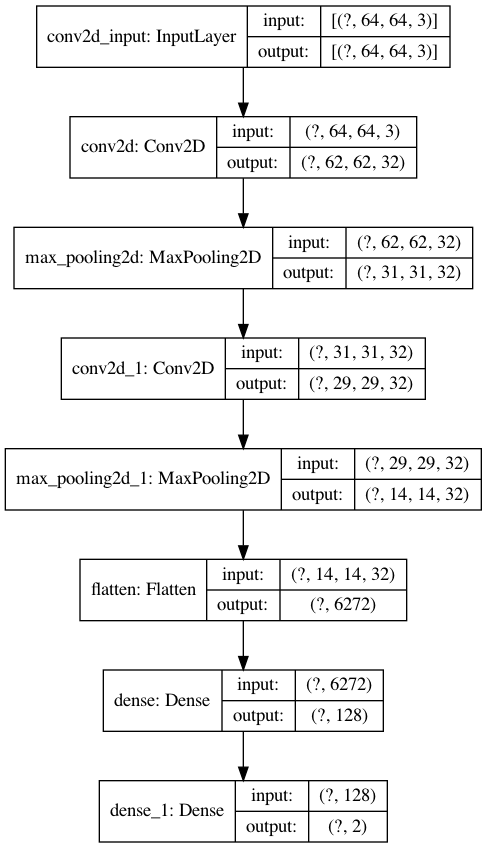

In [4]:
model = build_simplenet()
model.summary()
plot_model(model, show_shapes=True)

## Training

In [5]:
def train_simplenet( model,
               target_size,
               dataset_path,
               training_path_prefix,
               test_path_prefix,                        
               history_file_path,
               history_filename,
               checkpoint_path,
               checkpoint_prefix,
               number_of_epochs,
               tensorboard_log_path
            ):
    """
        see: https://keras.io/preprocessing/image/
    """
    train_datagen = ImageDataGenerator( rescale=1./255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True )
        
    test_datagen = ImageDataGenerator(rescale=1./255)
    training_set_generator = train_datagen.flow_from_directory(
            dataset_path+training_path_prefix,
            target_size,
            batch_size=32,
            class_mode='categorical',
            shuffle=True,
            seed=42
        )
    test_set_generator = test_datagen.flow_from_directory(
            dataset_path+test_path_prefix,
            target_size,
            batch_size=32,
            class_mode='categorical',
            shuffle=True,
            seed=42
        )
        
    step_size_train=training_set_generator.n//training_set_generator.batch_size
    step_size_validation=test_set_generator.n//test_set_generator.batch_size

    check_pointer = ModelCheckpoint(
            checkpoint_path + '%s_weights.{epoch:02d}-{val_loss:.2f}.hdf5' % checkpoint_prefix, 
            monitor='val_loss', 
            mode='auto', 
            save_best_only=True
    )
    
    tensorboard_logger = TensorBoard( 
        log_dir=tensorboard_log_path, histogram_freq=0,  
          write_graph=True, write_images=True
    )
    tensorboard_logger.set_model(model)

    csv_logger = CSVLogger(filename=history_file_path+history_filename)
    history = model.fit_generator(
            training_set_generator,
            steps_per_epoch=step_size_train,
            epochs=number_of_epochs,
            validation_data=test_set_generator,
            validation_steps=step_size_validation,
            callbacks=[check_pointer, csv_logger,tensorboard_logger] 
    )

In [6]:
MODEL_NAME="simplenet_cracks8020"

In [7]:
train_cracknet(  model,
            target_size=(120,120),
            dataset_path=DATA_BASE_PATH+"/datasets/cracks_splitted8020/",
            training_path_prefix="train_set",
            test_path_prefix="test_set",
            history_file_path=WORKSPACE_BASE_PATH+"/training_logs/",
            history_filename=MODEL_NAME+".csv",
            checkpoint_path=WORKSPACE_BASE_PATH+"/model-checkpoints/",
            checkpoint_prefix=MODEL_NAME,
            number_of_epochs=30, 
            tensorboard_log_path=WORKSPACE_BASE_PATH+"/tensorboard_logs/",
)

NameError: name 'train_cracknet' is not defined

## Training Report

In [ ]:
import matplotlib
from utils.plotutils import plot_learning_curves_from_history_file
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)
fig = plot_learning_curves_from_history_file(WORKSPACE_BASE_PATH+"/training_logs/"+MODEL_NAME+".csv")

## Export model to SavedModelFormat

In [ ]:
import glob
import os

list_of_files = glob.glob(WORKSPACE_BASE_PATH+'/model-checkpoints/*.hdf5') 
CHECKPOINT_FILE = max(list_of_files, key=os.path.getctime) # last checkpoint
VERSION=1
print(CHECKPOINT_FILE)

In [ ]:
from utils.export_tools import convert_from_keras_to_savedmodel

convert_from_keras_to_savedmodel(
    input_filename=CHECKPOINT_FILE,
    export_path=WORKSPACE_BASE_PATH+'/models/'+MODEL_NAME+"/"+str(VERSION)
)